## Module 2 Homework

In this homework, we're going to combine data from various sources to process it in Pandas and generate additional fields.

If not stated otherwise, please use the [LINK](https://github.com/DataTalksClub/stock-markets-analytics-zoomcamp/blob/main/02-dataframe-analysis/%5B2025%5D_Module_02_Colab_Working_with_the_data.ipynb) covered at the livestream to re-use the code snippets.

---

---
### Question 1: [IPO] Withdrawn IPOs by Company Type

**What is the total withdrawn IPO value (in $ millions) for the company class with the highest total withdrawal value?**

From the withdrawn IPO list ([stockanalysis.com/ipos/withdrawn](https://stockanalysis.com/ipos/withdrawn/)), collect and process the data to find out which company type saw the most withdrawn IPO value.

#### Steps:
1. Use `pandas.read_html()` with the URL above to load the IPO withdrawal table into a DataFrame. 
   *It is a similar process to Code Snippet 1 discussed at the livestream.*    You should get **99 entries**. 
2. Create a new column called `Company Class`, categorizing company names based on patterns like:
   - “Acquisition Corp” or “Acquisition Corporation” → `Acq.Corp`
   - “Inc” or “Incorporated” → `Inc`
   - “Group” → `Group`
   - “Holdings” → `Holdings`
   - “Ltd” or “Limited” → `Ltd`
   - Others → `Other`

  * Hint: make your function more robust by converting names to lowercase and splitting into words before matching patterns.

3. Define a new field `Avg. price` by parsing the `Price Range` field (create a function and apply it to the `Price Range` column). Examples:
   - '$8.00-$10.00' → `9.0`  
   - '$5.00' → `5.0`  
   - '-' → `None`
4. Convert `Shares Offered` to numeric, clean missing or invalid values.
5. Create a new column:  
   `Withdrawn Value = Shares Offered * Avg Price` (**71 non-null values**)
6. Group by `Company Class` and calculate total withdrawn value.
7. **Answer**: Which class had the highest **total** value of withdrawals?
---

In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import requests


#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt
     

In [2]:

import pandas as pd
import requests
from io import StringIO

def get_ipos(url):
    """
    Fetch IPO data for the given year from stockanalysis.com.
    """
    url = f"https://stockanalysis.com/ipos/withdrawn"
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/58.0.3029.110 Safari/537.3'
        )
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        # Wrap HTML text in StringIO to avoid deprecation warning
        # "Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object."
        html_io = StringIO(response.text)
        tables = pd.read_html(html_io)

        if not tables:
            raise ValueError(f"No tables found for year {year}.")

        return tables[0]

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    except ValueError as ve:
        print(f"Data error: {ve}")
    except Exception as ex:
        print(f"Unexpected error: {ex}")

    return pd.DataFrame()

In [3]:
ipo_wdr = get_ipos("https://stockanalysis.com/ipos/withdrawn")

print(ipo_wdr.info())
print(ipo_wdr.isnull().sum())

ipo_wdr.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Symbol          100 non-null    object
 1   Company Name    100 non-null    object
 2   Price Range     100 non-null    object
 3   Shares Offered  100 non-null    object
dtypes: object(4)
memory usage: 3.3+ KB
None
Symbol            0
Company Name      0
Price Range       0
Shares Offered    0
dtype: int64


,Symbol,Company Name,Price Range,Shares Offered
0,ODTX,"Odyssey Therapeutics, Inc.",-,-
1,UNFL,"Unifoil Holdings, Inc.",$3.00 - $4.00,2000000
2,AURN,"Aurion Biotech, Inc.",-,-
3,ROTR,"PHI Group, Inc.",-,-
4,ONE,One Power Company,-,-


In [4]:
def classify_company(name):
    name = name.lower()
    if "acquisition corp" in name or "acquisition corporation" in name:
        return "Acq.Corp"
    elif "inc" in name or "incorporated" in name:
        return "Inc"
    elif "group" in name:
        return "Group"
    elif "holdings" in name:
        return "Holdings"
    elif "ltd" in name or "limited" in name:
        return "Ltd"
    else:
        return "Other"



import numpy as np
import re

def extract_price(price_range):
    # Handle empty or '--' cases
    if pd.isna(price_range) or price_range == '--':
        return np.nan
    
    # Remove $ and M characters
    cleaned_price = price_range.replace('$', '').replace('M', '')
    
    # Check if it's a range (contains a hyphen)
    if '-' in cleaned_price:
        # Extract the two values from the range
        values = re.findall(r'\d+\.?\d*', cleaned_price)
        if len(values) >= 2:
            # Calculate midpoint
            return (float(values[0]) + float(values[1])) / 2
    else:
        # For absolute values
        values = re.findall(r'\d+\.?\d*', cleaned_price)
        if values:
            return float(values[0])
    
    # Fallback if no numbers found
    return np.nan






In [5]:
ipo_wdr["Company Class"] = ipo_wdr["Company Name"].apply(classify_company)

ipo_wdr["Amount"] = ipo_wdr["Price Range"].apply(extract_price)

ipo_wdr["Shares Offered"] = pd.to_numeric(ipo_wdr["Shares Offered"], errors='coerce')

# Amount is already the average price from your previous step
ipo_wdr["Withdrawn Value"] = ipo_wdr["Shares Offered"] * ipo_wdr["Amount"]

# 3. Group by 'Company Class' and calculate total withdrawn value
class_totals = ipo_wdr.groupby("Company Class")["Withdrawn Value"].sum().sort_values(ascending=False)

# 4. Find the class with the highest total withdrawn value
highest_class = class_totals.index[0]
highest_value = class_totals.iloc[0]

print(f"Class totals (in descending order):\n{class_totals}")
print(f"\nThe class with the highest total value of withdrawals is: {highest_class}")
print(f"Total withdrawn value: {highest_value:,.2f}")

Class totals (in descending order):
Company Class
Acq.Corp    4.021000e+09
Inc         2.257164e+09
Other       7.679200e+08
Ltd         3.217346e+08
Holdings    3.030000e+08
Group       3.378750e+07
Name: Withdrawn Value, dtype: float64

The class with the highest total value of withdrawals is: Acq.Corp
Total withdrawn value: 4,021,000,000.00


### Question 2:   [IPO] Median Sharpe Ratio for 2024 IPOs (First 5 Months)


**What is the median Sharpe ratio (as of 6 June 2025) for companies that went public in the first 5 months of 2024?**

The goal is to replicate the large-scale `yfinance` OHLCV data download and perform basic financial calculations on IPO stocks.


#### Steps:

1. Using the same approach as in Question 1, download the IPOs in 2024 from:  
   [https://stockanalysis.com/ipos/2024/](https://stockanalysis.com/ipos/2024/)  
   Filter to keep only those IPOs **before 1 June 2024** (first 5 months of 2024).  
   ➤ You should have **75 tickers**.

2.  Use **Code Snippet 7** to download daily stock data for those tickers (via `yfinance`).  
   Make sure you understand how `growth_1d` ... `growth_365d`, and volatility columns are defined.  
   Define a new column `growth_252d` representing growth after **252 trading days** (~1 year), in addition to any other growth periods you already track.


3. Calculate the Sharpe ratio assuming a risk-free rate of **4.5%**:

   ```python
   stocks_df['Sharpe'] = (stocks_df['growth_252d'] - 0.045) / stocks_df['volatility']
4. Filter the DataFrame to keep data only for the trading day:  
   **‘2025-06-06’**

   Compute descriptive statistics (e.g., `.describe()`) for these columns:  
   - `growth_252d`  
   - `Sharpe`

   You should observe:  
   - `growth_252d` is defined for **71 out of 75 stocks** (some IPOs are too recent or data starts later).  
   - Median `growth_252d` is approximately **0.75** (indicating a 25% decline), while mean is about **1.15**, showing a bias towards high-growth companies pushing the average up.

5. **Answer:**  
   - What is the **median Sharpe ratio** for these 71 stocks?  
   - Note: Positive `Sharpe` means growth exceeding the risk-free rate of 4.5%.  
   - [Additional] Do you observe the **same top 10 companies** when sorting by `growth_252d` versus sorting by `Sharpe`?

---

In [6]:
import pandas as pd
import requests
from io import StringIO

def get_ipos_by_year(year: int) -> pd.DataFrame:
    """
    Fetch IPO data for the given year from stockanalysis.com.
    """
    url = f"https://stockanalysis.com/ipos/{year}/"
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/58.0.3029.110 Safari/537.3'
        )
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        # Wrap HTML text in StringIO to avoid deprecation warning
        # "Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object."
        html_io = StringIO(response.text)
        tables = pd.read_html(html_io)

        if not tables:
            raise ValueError(f"No tables found for year {year}.")

        return tables[0]

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    except ValueError as ve:
        print(f"Data error: {ve}")
    except Exception as ex:
        print(f"Unexpected error: {ex}")

    return pd.DataFrame()

In [7]:
ipos_2024 = get_ipos_by_year(2024)

ipos_2024['IPO Date'] = pd.to_datetime(ipos_2024['IPO Date'], errors='coerce')

ipos_2024['IPO Price'] = pd.to_numeric(ipos_2024['IPO Price'].str.replace('$', ''), errors='coerce')
# not sure why, but need to call it again to transform 'object' to 'float64'
ipos_2024['IPO Price'] = pd.to_numeric(ipos_2024['IPO Price'])

# Convert "Current" column
ipos_2024['Current'] = pd.to_numeric(ipos_2024['Current'].str.replace('$', ''), errors='coerce')

# Convert 'Return' to numeric format (percentage)
ipos_2024['Return'] = pd.to_numeric(ipos_2024['Return'].str.replace('%', ''), errors='coerce') / 100

ipos_2024.info()

print(ipos_2024.isnull().sum())

ipos_2024



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   IPO Date      225 non-null    datetime64[ns]
 1   Symbol        225 non-null    object        
 2   Company Name  225 non-null    object        
 3   IPO Price     221 non-null    float64       
 4   Current       225 non-null    float64       
 5   Return        221 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 10.7+ KB
IPO Date        0
Symbol          0
Company Name    0
IPO Price       4
Current         0
Return          4
dtype: int64


,IPO Date,Symbol,Company Name,IPO Price,Current,Return
0,2024-12-31,ONEG,OneConstruction Group Limited,4.00,3.60,-0.1000
1,2024-12-27,PHH,"Park Ha Biological Technology Co., Ltd.",4.00,18.86,3.7150
2,2024-12-23,HIT,"Health In Tech, Inc.",4.00,0.60,-0.8549
3,2024-12-23,TDAC,Translational Development Acquisition Corp.,10.00,10.25,0.0250
4,2024-12-20,RANG,Range Capital Acquisition Corp.,10.00,10.31,0.0310
...,...,...,...,...,...,...
220,2024-01-18,CCTG,CCSC Technology International Holdings Limited,6.00,1.04,-0.8267
221,2024-01-18,PSBD,Palmer Square Capital BDC Inc.,16.45,13.96,-0.1514
222,2024-01-12,SYNX,Silynxcom Ltd.,4.00,1.72,-0.5725
223,2024-01-11,SDHC,Smith Douglas Homes Corp.,21.00,19.43,-0.0748


In [52]:
ipos_2024_final = ipos_2024[
    (ipos_2024['IPO Date'].dt.year == 2024) &
    (ipos_2024['IPO Date'].dt.month < 6)
]
ipos_2024_final.shape

(77, 6)

In [38]:
ipo_tickers = ipos_2024_final['Symbol'].dropna().unique()
print(len(ipo_tickers))
ipo_tickers

77


array(['NAKA', 'BOW', 'HDL', 'RFAI', 'JDZG', 'RAY', 'BTOC', 'ZK', 'GPAT',
       'PAL', 'SVCO', 'NNE', 'CCIX', 'VIK', 'ZONE', 'LOAR', 'MRX', 'RBRK',
       'NCI', 'MFI', 'YYGH', 'TRSG', 'CDTG', 'CTRI', 'IBTA', 'MTEN',
       'SUPX', 'TWG', 'ULS', 'PACS', 'MNDR', 'CTNM', 'MAMO', 'ZBAO',
       'BOLD', 'MMA', 'UBXG', 'IBAC', 'AUNA', 'BKHA', 'LOBO', 'RDDT',
       'ALAB', 'INTJ', 'RYDE', 'LGCL', 'SMXT', 'VHAI', 'DYCQ', 'CHRO',
       'UMAC', 'HLXB', 'MGX', 'TBBB', 'TELO', 'KYTX', 'PMNT', 'AHR',
       'LEGT', 'ANRO', 'GUTS', 'AS', 'FBLG', 'AVBP', 'BTSG', 'HAO',
       'CGON', 'YIBO', 'JL', 'SUGP', 'JVSA', 'KSPI', 'CCTG', 'PSBD',
       'SYNX', 'SDHC', 'ROMA'], dtype=object)

In [39]:
stocks_df = pd.DataFrame({'A' : []})
# Fetch historical data for each IPO ticker


for i, ticker in enumerate(ipo_tickers):
    print(i, ticker)

    try:
        ticker_obj = yf.Ticker(ticker)
        historyPrices = ticker_obj.history(period="max", interval="1d")

        if historyPrices.empty:
            print(f"Warning: No data found for {ticker}")
            continue

        # Continue processing as before...

        # Add your columns/features
        historyPrices['Ticker'] = ticker
        historyPrices['Year'] = historyPrices.index.year
        historyPrices['Month'] = historyPrices.index.month
        historyPrices['Weekday'] = historyPrices.index.weekday
        historyPrices['Date'] = historyPrices.index.date

        for j in [1, 3, 7, 30, 90, 252, 365]:
            historyPrices[f'growth_{j}d'] = historyPrices['Close'] / historyPrices['Close'].shift(j)

        historyPrices['growth_future_30d'] = historyPrices['Close'].shift(-30) / historyPrices['Close']
        historyPrices['SMA10'] = historyPrices['Close'].rolling(10).mean()
        historyPrices['SMA20'] = historyPrices['Close'].rolling(20).mean()
        historyPrices['growing_moving_average'] = np.where(historyPrices['SMA10'] > historyPrices['SMA20'], 1, 0)
        historyPrices['high_minus_low_relative'] = (historyPrices.High - historyPrices.Low) / historyPrices['Close']
        historyPrices['volatility'] = historyPrices['Close'].rolling(30).std() * np.sqrt(252)
        historyPrices['Sharpe'] = (historyPrices['growth_252d'] - 0.045) / historyPrices['volatility']
        historyPrices['is_positive_growth_30d_future'] = np.where(historyPrices['growth_future_30d'] > 1, 1, 0)
        

        if stocks_df.empty:
            stocks_df = historyPrices
        else:
            stocks_df = pd.concat([stocks_df, historyPrices], ignore_index=True)

    except Exception as e:
        print(f"Error for ticker {ticker}: {e}")
    
    time.sleep(1)


0 NAKA
1 BOW
2 HDL
3 RFAI
4 JDZG
5 RAY
6 BTOC
7 ZK
8 GPAT
9 PAL
10 SVCO
11 NNE
12 CCIX
13 VIK
14 ZONE
15 LOAR
16 MRX
17 RBRK
18 NCI
19 MFI
20 YYGH
21 TRSG
22 CDTG
23 CTRI
24 IBTA
25 MTEN
26 SUPX
27 TWG
28 ULS
29 PACS
30 MNDR
31 CTNM
32 MAMO
33 ZBAO
34 BOLD
35 MMA
36 UBXG
37 IBAC
38 AUNA
39 BKHA
40 LOBO
41 RDDT
42 ALAB
43 INTJ
44 RYDE
45 LGCL
46 SMXT
47 VHAI
48 DYCQ
49 CHRO
50 UMAC
51 HLXB
52 MGX
53 TBBB
54 TELO
55 KYTX
56 PMNT
57 AHR
58 LEGT
59 ANRO
60 GUTS
61 AS
62 FBLG
63 AVBP
64 BTSG
65 HAO
66 CGON
67 YIBO
68 JL
69 SUGP
70 JVSA
71 KSPI
72 CCTG
73 PSBD
74 SYNX
75 SDHC
76 ROMA


In [40]:
stocks_df.groupby(['Ticker']).Date.agg(['min','max'])

,min,max
Ticker,,
AHR,2024-02-07,2025-06-12
ALAB,2024-03-20,2025-06-12
ANRO,2024-02-02,2025-06-12
AS,2024-02-01,2025-06-12
AUNA,2024-03-22,2025-06-12
...,...,...
YIBO,2024-01-25,2025-06-12
YYGH,2024-04-22,2025-06-12
ZBAO,2024-04-02,2025-06-12


In [11]:
#stocks_df['Sharpe'] = (stocks_df['growth_252d'] - 0.045) / stocks_df['volatility']

In [41]:
from datetime import date

# Define the date you're interested in
specific_date = date(2025, 6, 6)

# Filter the DataFrame
filtered_df = stocks_df[stocks_df['Date'] == specific_date]
filtered_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_252d,growth_365d,growth_future_30d,SMA10,SMA20,growing_moving_average,high_minus_low_relative,volatility,Sharpe,is_positive_growth_30d_future
254,16.260000,17.200001,15.550000,15.880000,431200,0.0,0.0,NAKA,2025,6,...,5.438356,NaN,NaN,20.5610,17.24800,1,0.103904,136.860031,0.039408,0
518,36.439999,36.540001,35.930000,36.389999,137900,0.0,0.0,BOW,2025,6,...,1.442331,NaN,NaN,36.9540,37.70400,0,0.016763,24.508713,0.057014,0
786,20.430000,20.440001,19.969999,20.410000,1300,0.0,0.0,HDL,2025,6,...,1.007155,NaN,NaN,19.9660,21.08215,0,0.023028,18.816306,0.051134,0
1022,10.510000,10.510000,10.510000,10.510000,0,0.0,0.0,RFAI,2025,6,...,NaN,NaN,NaN,10.4930,10.47935,1,0.000000,0.356043,NaN,0
1292,0.380000,0.386000,0.201000,0.295000,3428900,0.0,0.0,JDZG,2025,6,...,0.168571,NaN,NaN,0.4883,0.52880,0,0.627119,1.475159,0.083768,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22071,1.075000,1.100000,1.075000,1.095000,1600,0.0,0.0,CCTG,2025,6,...,0.500000,NaN,NaN,1.1434,1.18080,0,0.022831,1.297728,0.350613,0
22423,13.900000,14.000000,13.750000,13.880000,56200,0.0,0.0,PSBD,2025,6,...,0.947565,NaN,NaN,13.9030,13.74250,1,0.018012,9.712591,0.092927,0
22778,1.750000,1.750000,1.680000,1.680000,10000,0.0,0.0,SYNX,2025,6,...,0.626632,NaN,NaN,1.7435,1.82090,0,0.041667,1.368371,0.425054,0
23132,19.900000,20.150000,19.270000,19.270000,38100,0.0,0.0,SDHC,2025,6,...,0.758065,NaN,NaN,18.6850,18.66500,1,0.045667,16.442821,0.043366,0


In [42]:
filtered_df[['Sharpe','growth_252d']].describe()

,Sharpe,growth_252d
count,73.000000,73.000000
mean,0.297523,1.227948
std,0.523190,1.480237
min,-0.079677,0.024970
25%,0.040265,0.293510
50%,0.083768,0.763188
75%,0.331967,1.446667
max,2.835668,8.097413


In [43]:
f"Median of sharpe is {float(filtered_df['Sharpe'].median())*100:.1f}%"

'Median of sharpe is 8.4%'

### Question 3: [IPO] ‘Fixed Months Holding Strategy’

**What is the optimal number of months (1 to 12) to hold a newly IPO'd stock in order to maximize average growth?**  
(*Assume you buy at the close of the first trading day and sell after a fixed number of trading days.*)


---

#### Goal:
Investigate whether holding an IPO stock for a fixed number of months after its first trading day produces better returns, using future growth columns.

---

#### Steps:

1. **Start from the existing DataFrame** from Question 2 (75 tickers from IPOs in the first 5 months of 2024).  

   Add **12 new columns**:  
   `future_growth_1m`, `future_growth_2m`, ..., `future_growth_12m`  
   *(Assume 1 month = 21 trading days, so growth is calculated over 21, 42, ..., 252 trading days)*  
   This logic is similar to `historyPrices['growth_future_30d']` from **Code Snippet 7**, but extended to longer timeframes.

2. **Determine the first trading day** (`min_date`) for each ticker.  
   This is the earliest date in the data for each stock.

3. **Join the data**:  
   Perform an **inner join** between the `min_date` DataFrame and the future growth data on both `ticker` and `date`.  
   ➤ You should end up with **75 records** (one per IPO) with all 12 `future_growth_...` fields populated.

4. **Compute descriptive statistics** for the resulting DataFrame:  
   Use `.describe()` or similar to analyze each of the 12 columns:  
   - `future_growth_1m`  
   - `future_growth_2m`  
   - ...  
   - `future_growth_12m`  

5. **Determine the best holding period**:  
   - Find the number of months **(1 to 12)** where the **average (mean)** future growth is **maximal**.  
   - This optimal month shows an uplift of **>1%** compared to all others.  
   - Still, the average return remains **less than 1** (i.e., expected return is less than doubling your investment).



In [44]:
# Define month steps in trading days
month_days = [21 * i for i in range(1, 13)]  # [21, 42, ..., 252]

# Loop to create future growth columns
for days in month_days:
    col_name = f'future_growth_{days//21}m'
    stocks_df[col_name] = stocks_df['Close'].shift(-days) / stocks_df['Close']


stocks_df.sort_values(['Ticker', 'Date'], inplace=True)
stocks_df.reset_index(drop=True, inplace=True)

stocks_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,future_growth_3m,future_growth_4m,future_growth_5m,future_growth_6m,future_growth_7m,future_growth_8m,future_growth_9m,future_growth_10m,future_growth_11m,future_growth_12m
0,12.085784,12.471401,11.878868,12.433780,12732800,0.0,0.0,AHR,2024,2,...,1.060660,1.125316,1.214961,1.308118,1.753552,1.963886,1.988395,2.257204,2.259752,2.273312
1,12.245675,12.452590,12.226864,12.283296,1630300,0.0,0.0,AHR,2024,2,...,1.094691,1.156243,1.267090,1.324937,1.817034,1.951132,2.105590,2.256847,2.197812,2.230109
2,12.236270,12.650102,12.179838,12.339727,2062100,0.0,0.0,AHR,2024,2,...,1.086582,1.157160,1.262084,1.352007,1.803991,1.927870,2.077638,2.219440,2.180527,2.207050
3,13.120365,13.694088,12.320917,12.367943,1161200,0.0,0.0,AHR,2024,2,...,1.090294,1.151425,1.278880,1.390634,1.864410,1.953675,2.103896,2.231068,2.194798,2.278196
4,12.367943,12.753560,12.236270,12.556049,1631700,0.0,0.0,AHR,2024,2,...,1.067100,1.131888,1.289178,1.399259,1.905472,1.933801,2.028534,2.218782,2.205361,2.222738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23490,3.500000,4.420000,3.487000,4.340000,364400,0.0,0.0,ZONE,2025,6,...,12.843318,17.154377,16.970046,17.914746,18.617512,17.585253,18.983870,15.990783,14.970046,19.094470
23491,4.350000,4.500000,3.780000,3.890000,172500,0.0,0.0,ZONE,2025,6,...,15.372750,18.624677,19.442158,20.177377,21.061696,19.197943,21.061696,17.637532,17.228790,22.092545
23492,3.900000,3.955000,3.610000,3.790000,79600,0.0,0.0,ZONE,2025,6,...,16.403694,18.467018,19.646438,21.050132,23.155674,19.496042,21.295514,17.889183,18.092348,24.234828
23493,3.730000,4.100000,3.500000,3.720000,132300,0.0,0.0,ZONE,2025,6,...,16.088709,18.241936,20.303763,21.784946,23.672042,19.577957,21.438172,18.268817,17.900537,26.045699


In [45]:
# Step 2: Get the first trading date for each ticker
min_date_df = stocks_df.groupby('Ticker')['Date'].min().reset_index()
min_date_df.rename(columns={'Date': 'min_date'}, inplace=True)
min_date_df

,Ticker,min_date
0,AHR,2024-02-07
1,ALAB,2024-03-20
2,ANRO,2024-02-02
3,AS,2024-02-01
4,AUNA,2024-03-22
...,...,...
72,YIBO,2024-01-25
73,YYGH,2024-04-22
74,ZBAO,2024-04-02
75,ZK,2024-05-10


In [46]:
# Prepare a base DataFrame with Date and Ticker to match on
join_base = stocks_df[['Ticker', 'Date'] + [col for col in stocks_df.columns if col.startswith('future_growth_')]]

# Inner join on ticker and date == min_date
joined_df = min_date_df.merge(join_base, left_on=['Ticker', 'min_date'], right_on=['Ticker', 'Date'], how='inner')

joined_df.drop(columns=['Date'], inplace=True)

joined_df

,Ticker,min_date,future_growth_1m,future_growth_2m,future_growth_3m,future_growth_4m,future_growth_5m,future_growth_6m,future_growth_7m,future_growth_8m,future_growth_9m,future_growth_10m,future_growth_11m,future_growth_12m
0,AHR,2024-02-07,1.044629,1.061430,1.060660,1.125316,1.214961,1.308118,1.753552,1.963886,1.988395,2.257204,2.259752,2.273312
1,ALAB,2024-03-20,1.039658,1.168951,1.018217,0.853780,0.631307,0.759794,1.078027,1.457037,1.974367,1.982105,1.381912,1.189424
2,ANRO,2024-02-02,0.772947,0.680193,0.686957,0.546377,0.563768,0.438164,0.647343,0.492270,0.192271,0.203865,0.222705,0.202899
3,AS,2024-02-01,1.294030,1.172388,1.080597,1.143284,0.935075,0.802239,0.999254,1.236567,1.332090,1.950000,2.152985,2.362687
4,AUNA,2024-03-22,0.713542,0.923958,0.801042,0.919792,0.782292,0.767708,0.723958,0.733333,0.706250,0.857292,0.850000,0.752083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,YIBO,2024-01-25,0.931900,0.931900,0.734767,0.788530,0.723656,1.044803,0.777778,0.957706,0.996416,1.290323,1.326165,1.842294
73,YYGH,2024-04-22,0.568965,0.293103,0.246897,0.255172,0.315517,0.431034,0.631034,0.675862,0.634483,0.606897,0.617241,0.355172
74,ZBAO,2024-04-02,0.966757,1.245946,1.075676,1.037838,0.891892,1.005405,0.851351,0.770270,0.424324,0.418919,0.370270,0.300541
75,ZK,2024-05-10,0.782732,0.691437,0.508139,0.598726,0.869073,0.878627,0.998231,0.961076,0.877212,1.105096,0.756546,1.018401


In [47]:
joined_df.groupby('Ticker')['min_date'].size()

Ticker
AHR     1
ALAB    1
ANRO    1
AS      1
AUNA    1
       ..
YIBO    1
YYGH    1
ZBAO    1
ZK      1
ZONE    1
Name: min_date, Length: 77, dtype: int64

In [48]:
joined_df.describe()

,future_growth_1m,future_growth_2m,future_growth_3m,future_growth_4m,future_growth_5m,future_growth_6m,future_growth_7m,future_growth_8m,future_growth_9m,future_growth_10m,future_growth_11m,future_growth_12m
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,0.926390,0.936667,0.833961,0.822608,0.802803,0.864268,0.846216,0.829911,12.185790,12.276197,12.304126,12.394812
std,0.342767,0.568754,0.410637,0.401664,0.486836,0.649214,0.706519,0.754321,99.127183,99.713686,100.108229,99.900698
min,0.098947,0.073800,0.060947,0.045368,0.054109,0.061432,0.044086,0.043103,0.033144,0.037769,0.023674,0.038947
25%,0.775236,0.680193,0.508139,0.515385,0.445378,0.387417,0.324100,0.225974,0.278788,0.251515,0.271143,0.229851
50%,0.977000,1.000000,0.927500,0.909091,0.821092,0.802239,0.844875,0.812109,0.844000,0.777871,0.756546,0.752083
75%,1.047796,1.139076,1.075676,1.125316,1.017822,1.103896,1.150909,1.074739,1.061815,1.203758,1.326165,1.472441
max,2.646505,4.874759,2.040000,1.605000,3.213873,3.670520,5.122350,5.171484,870.689699,875.862067,879.310340,877.586244


In [49]:
# Step 4: Descriptive statistics for future growth columns
growth_cols = [f'future_growth_{i}m' for i in range(1, 13)]
joined_df[growth_cols].describe()


,future_growth_1m,future_growth_2m,future_growth_3m,future_growth_4m,future_growth_5m,future_growth_6m,future_growth_7m,future_growth_8m,future_growth_9m,future_growth_10m,future_growth_11m,future_growth_12m
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,0.926390,0.936667,0.833961,0.822608,0.802803,0.864268,0.846216,0.829911,12.185790,12.276197,12.304126,12.394812
std,0.342767,0.568754,0.410637,0.401664,0.486836,0.649214,0.706519,0.754321,99.127183,99.713686,100.108229,99.900698
min,0.098947,0.073800,0.060947,0.045368,0.054109,0.061432,0.044086,0.043103,0.033144,0.037769,0.023674,0.038947
25%,0.775236,0.680193,0.508139,0.515385,0.445378,0.387417,0.324100,0.225974,0.278788,0.251515,0.271143,0.229851
50%,0.977000,1.000000,0.927500,0.909091,0.821092,0.802239,0.844875,0.812109,0.844000,0.777871,0.756546,0.752083
75%,1.047796,1.139076,1.075676,1.125316,1.017822,1.103896,1.150909,1.074739,1.061815,1.203758,1.326165,1.472441
max,2.646505,4.874759,2.040000,1.605000,3.213873,3.670520,5.122350,5.171484,870.689699,875.862067,879.310340,877.586244


In [50]:
# Step 5: Find optimal fixed-month holding period
mean_returns = joined_df[growth_cols].mean()
optimal_month = mean_returns.idxmax()
optimal_month_num = int(optimal_month.split('_')[2][0:-1])  # extracts the number before 'm'

# Print summary
print("Average Returns by Holding Period (in months):")
print(mean_returns)

print(f"\n✅ Optimal Holding Period: {optimal_month_num} month(s)")
print(f"📈 Expected Growth: {mean_returns[optimal_month]:.4f}")

# Check uplift vs second-best
sorted_means = mean_returns.sort_values(ascending=False)
uplift = sorted_means.iloc[0] - sorted_means.iloc[1]

if uplift > 0.01 and sorted_means.iloc[0] < 1:
    print(f"📊 This period outperforms others by {uplift:.2%}, but does not double the investment (growth < 1)")
else:
    print("⚠️ No single month provides >1% uplift over others or growth exceeds 1.")


Average Returns by Holding Period (in months):
future_growth_1m      0.926390
future_growth_2m      0.936667
future_growth_3m      0.833961
future_growth_4m      0.822608
future_growth_5m      0.802803
future_growth_6m      0.864268
future_growth_7m      0.846216
future_growth_8m      0.829911
future_growth_9m     12.185790
future_growth_10m    12.276197
future_growth_11m    12.304126
future_growth_12m    12.394812
dtype: float64

✅ Optimal Holding Period: 12 month(s)
📈 Expected Growth: 12.3948
⚠️ No single month provides >1% uplift over others or growth exceeds 1.


In [53]:
clean_df = joined_df[
    joined_df[[f'future_growth_{i}m' for i in range(1, 13)]].notnull().all(axis=1)
]


mean_returns_cleaned = clean_df[[f'future_growth_{i}m' for i in range(1, 13)]].mean()
print("📊 Cleaned Average Returns by Holding Period:")
print(mean_returns_cleaned)


📊 Cleaned Average Returns by Holding Period:
future_growth_1m      0.926390
future_growth_2m      0.936667
future_growth_3m      0.833961
future_growth_4m      0.822608
future_growth_5m      0.802803
future_growth_6m      0.864268
future_growth_7m      0.846216
future_growth_8m      0.829911
future_growth_9m     12.185790
future_growth_10m    12.276197
future_growth_11m    12.304126
future_growth_12m    12.394812
dtype: float64


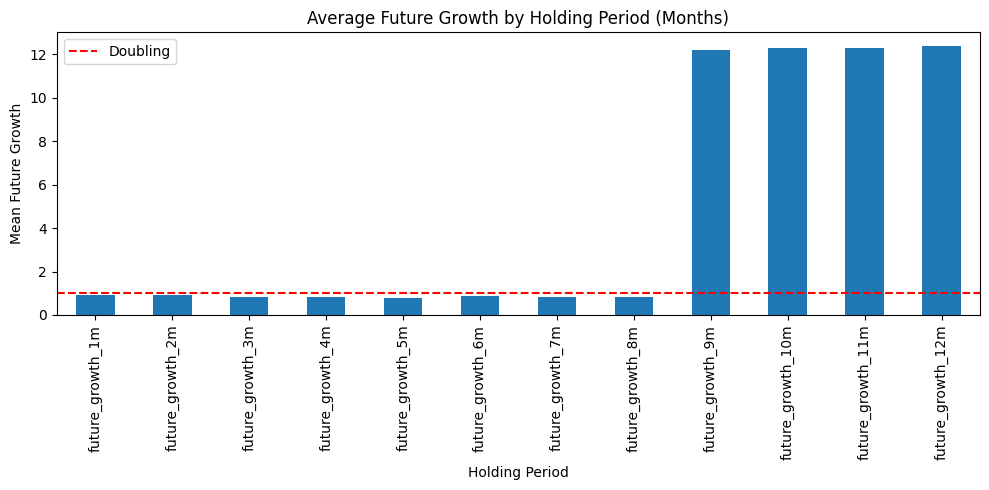

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
mean_returns.plot(kind='bar')
plt.title('Average Future Growth by Holding Period (Months)')
plt.xlabel('Holding Period')
plt.ylabel('Mean Future Growth')
plt.axhline(1.0, color='red', linestyle='--', label='Doubling')
plt.legend()
plt.tight_layout()
plt.show()
